Here we perform empirical dynamic modeling by explicitly computing the derivatives. The general outline is:
1. Prepare the dataset
2. Generate the training data
3. Train a model
4. Make predictions

One thing to consider in this cell cycle model is the limit cycle. Data points at the beginning (before the system stabilizes) may affect the accuracy of the prediction of the derivatives.

In [1]:
import sys
sys.path.append("./source")

from lmmNet import *
import harmonic
import train_onestep
import predict_onestep
import predict_lmmNet
import pickle
import matplotlib.pyplot as plt

# 1. Data Preparation

First of all, let's load the data to see what we have

In [2]:
# load data
with open('./data/cell_cycle.pkl', 'rb') as file:
    data_dict = pickle.load(file)
    
data_array = data_dict['data']
time_points = data_dict['t']
#print(data_array)

In [3]:
import pandas as pd

df = pd.DataFrame(data_array.numpy()[0])
df.columns = ['cyclin', 'MPF', 'preMPF', 'cdc25P', 'wee1P', 'IEP', 'APC']
df['Strain'] = [0] * df.shape[0]
df = df.set_index('Strain')
df.head()

,cyclin,MPF,preMPF,cdc25P,wee1P,IEP,APC
Strain,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
0,0.185745,0.008765,0.000595,0.000012,0.000006,0.970310,0.993761
0,0.345694,0.030825,0.004259,0.000085,0.000043,0.940683,0.991450
0,0.483463,0.061154,0.012881,0.000260,0.000133,0.911164,0.990087
0,0.602154,0.096144,0.027416,0.000560,0.000285,0.881781,0.989058


In [4]:
feature_list = [] # here we do not have external time-series
target_list = ['cyclin', 'MPF', 'preMPF', 'cdc25P', 'wee1P', 'IEP', 'APC']

# add time_points to df
df['Time'] = time_points
df.head()

,cyclin,MPF,preMPF,cdc25P,wee1P,IEP,APC,Time
Strain,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.0
0,0.185745,0.008765,0.000595,0.000012,0.000006,0.970310,0.993761,0.2
0,0.345694,0.030825,0.004259,0.000085,0.000043,0.940683,0.991450,0.4
0,0.483463,0.061154,0.012881,0.000260,0.000133,0.911164,0.990087,0.6
0,0.602154,0.096144,0.027416,0.000560,0.000285,0.881781,0.989058,0.8


In [5]:
steady_state = df[df.Time > 500]
steady_state.shape

(4999, 8)

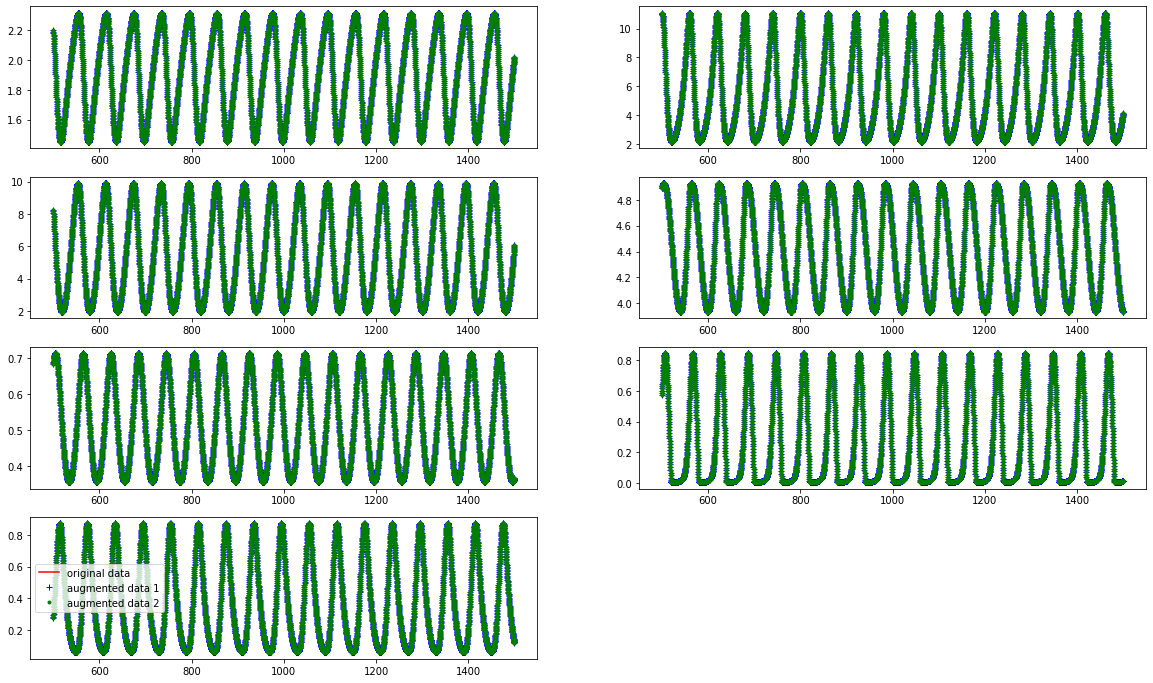

In [6]:
df_train1 = train_onestep.generate_dataset(steady_state, [0],feature_list, target_list, n_dim=5000)
df_train2 = train_onestep.generate_dataset(steady_state, [0],feature_list, target_list, n_dim=10000)

plt.figure(figsize = (20, 12))
for species in range(7):
    plt.subplot(4, 2, species + 1)
    plt.plot(steady_state.Time, steady_state.iloc[:,species], 'r-', label='original data')
    plt.plot(df_train1.index.get_level_values(1), df_train1[('feature', df.columns[species])], 'b+', label='augmented data 1')
    plt.plot(df_train2.index.get_level_values(1), df_train2[('feature', df.columns[species])], 'g.', label='augmented data 2')
    
plt.legend()

# 2. Training

In [7]:
# the features are the multi-dimensional time-series concentrations
# the target is the derivative of the dynamics
from sklearn.ensemble import RandomForestRegressor

# create a random forest model with 20 estimators
rf_model = RandomForestRegressor(n_estimators=20)

cyclin


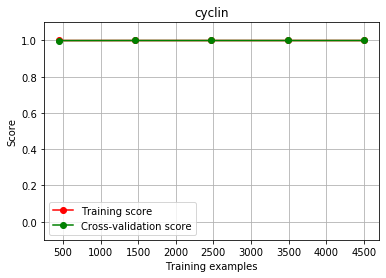

Target: cyclin, CV Pearson R2 coefficient: 0.999989
MPF


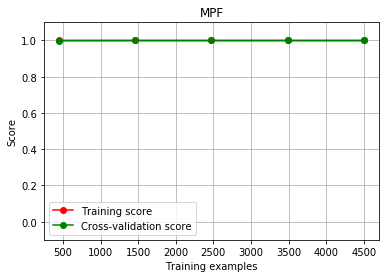

Target: MPF, CV Pearson R2 coefficient: 1.000000
preMPF


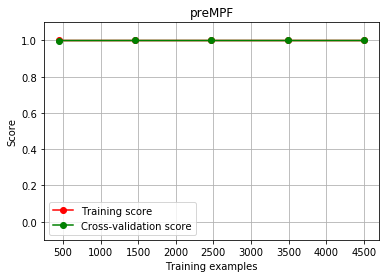

Target: preMPF, CV Pearson R2 coefficient: 1.000000
cdc25P


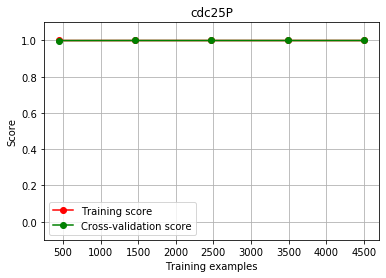

Target: cdc25P, CV Pearson R2 coefficient: 0.999995
wee1P


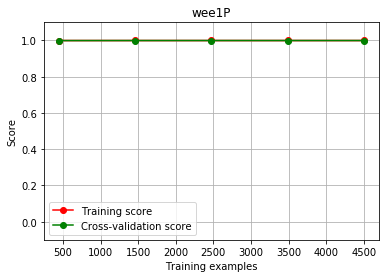

Target: wee1P, CV Pearson R2 coefficient: 0.999905
IEP


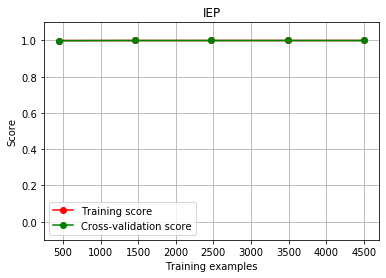

Target: IEP, CV Pearson R2 coefficient: 0.999992
APC


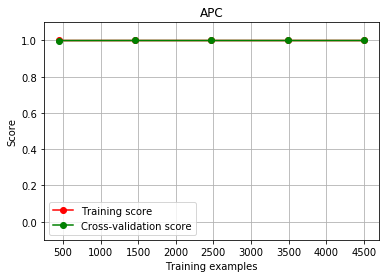

Target: APC, CV Pearson R2 coefficient: 0.999994
Average training score: 0.9999821361823208


In [8]:
from sklearn.base import clone
from sklearn.model_selection import ShuffleSplit

figure_path = './plots/'

# train a model
model_type = 'random_forest'
rf_dict1, score_dict1 = train_onestep.train_classic(df_train1, rf_model, plot=True,model_type=model_type, figure_path=figure_path)

cyclin


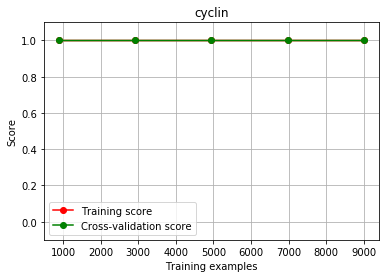

Target: cyclin, CV Pearson R2 coefficient: 0.999989
MPF


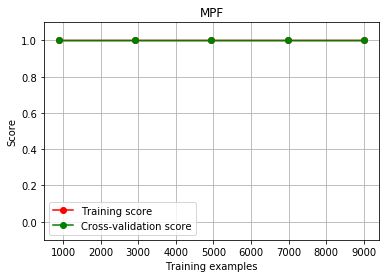

Target: MPF, CV Pearson R2 coefficient: 1.000000
preMPF


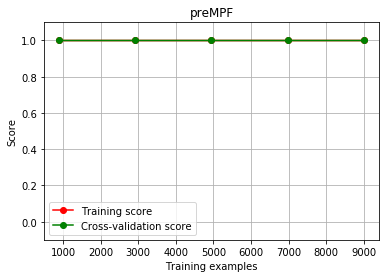

Target: preMPF, CV Pearson R2 coefficient: 1.000000
cdc25P


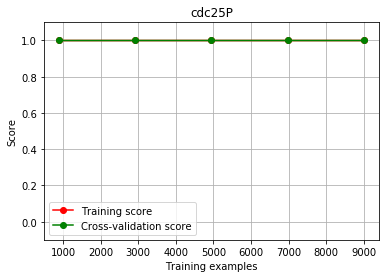

Target: cdc25P, CV Pearson R2 coefficient: 0.999995
wee1P


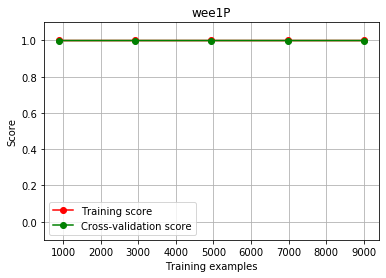

Target: wee1P, CV Pearson R2 coefficient: 0.999888
IEP


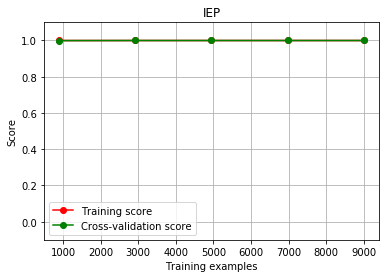

Target: IEP, CV Pearson R2 coefficient: 0.999994
APC


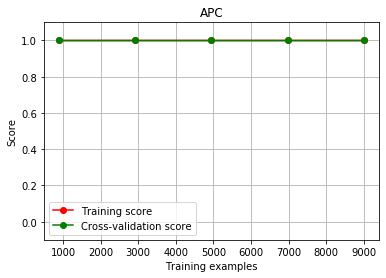

Target: APC, CV Pearson R2 coefficient: 0.999994
Average training score: 0.9999800355453177


In [9]:
rf_dict2, score_dict2 = train_onestep.train_classic(df_train2, rf_model, plot=True,model_type=model_type, figure_path=figure_path)

cyclin RMSE: -1.0075282962041917e-06 standard deviation: 0.00010908641754253532


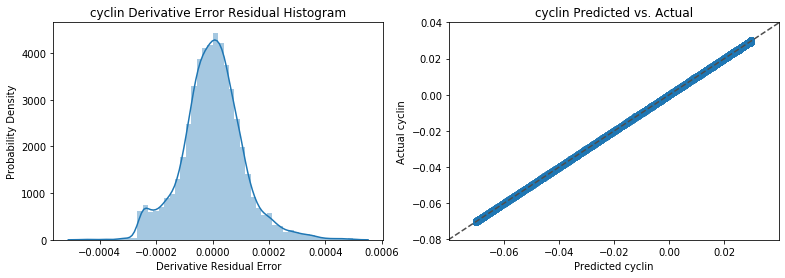

MPF RMSE: -2.3421762360496425e-06 standard deviation: 0.0002392117679937244


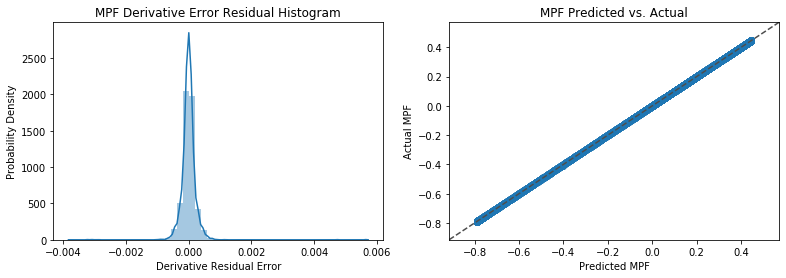

preMPF RMSE: 3.2899835369398473e-06 standard deviation: 0.00021203525828331922


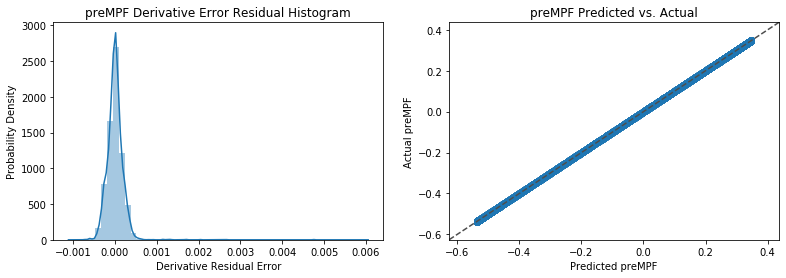

cdc25P RMSE: -1.198175684574921e-06 standard deviation: 9.068985908185619e-05


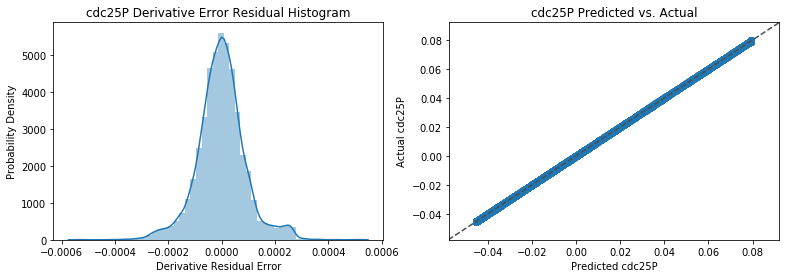

wee1P RMSE: -5.84507543944793e-07 standard deviation: 0.0001298689659326164


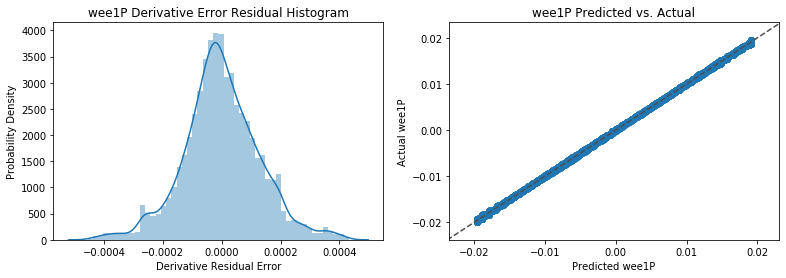

IEP RMSE: -1.8448553830230551e-06 standard deviation: 0.00011551296783035164


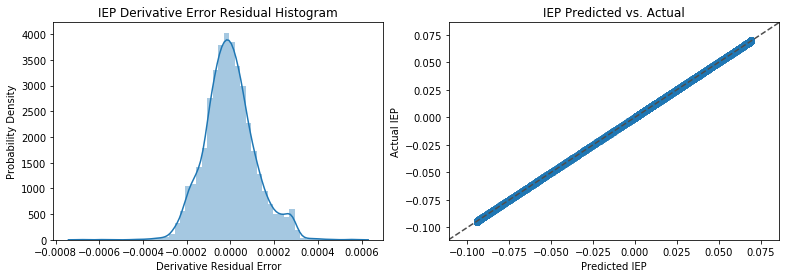

APC RMSE: 1.7417691532738193e-06 standard deviation: 8.164245822965585e-05


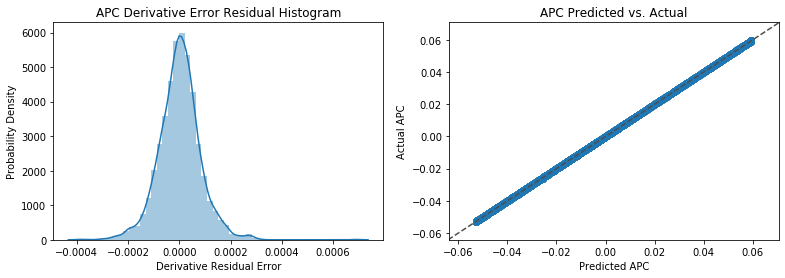

Total Derivative Mean Error: 0.8570227381652152 Error Standard Deviation: 0.015383882105333356


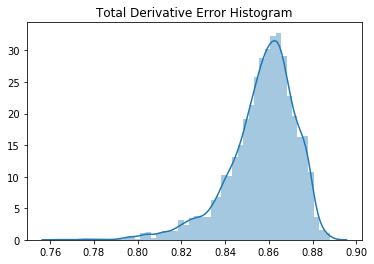

In [10]:
# compute the error
train_onestep.compute_error(df_train1,rf_dict1,plot=True,model_type=model_type)

cyclin RMSE: -3.6966740531704874e-08 standard deviation: 0.00011299178244102437


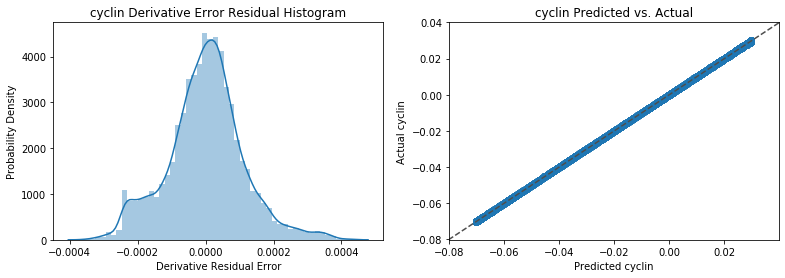

MPF RMSE: -4.519923374449258e-06 standard deviation: 0.00018125430263669958


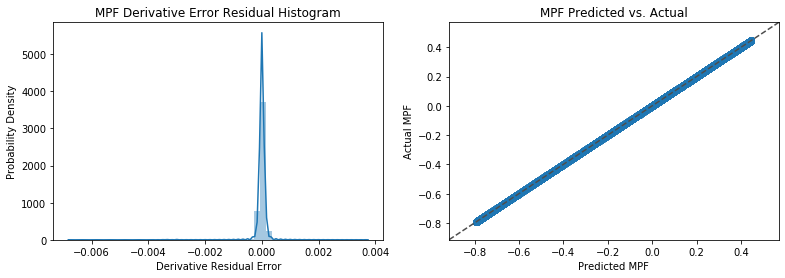

preMPF RMSE: 2.307105084489944e-06 standard deviation: 0.00011368722750283104


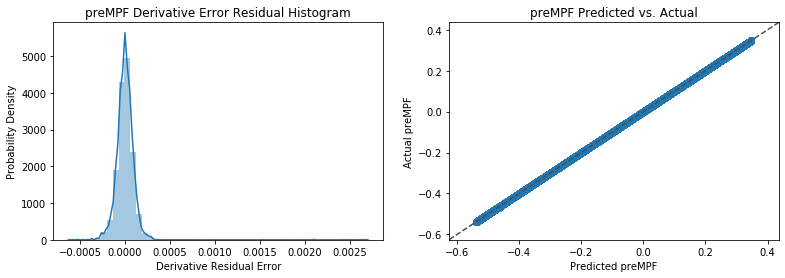

cdc25P RMSE: -1.485559097951441e-07 standard deviation: 8.527454788811084e-05


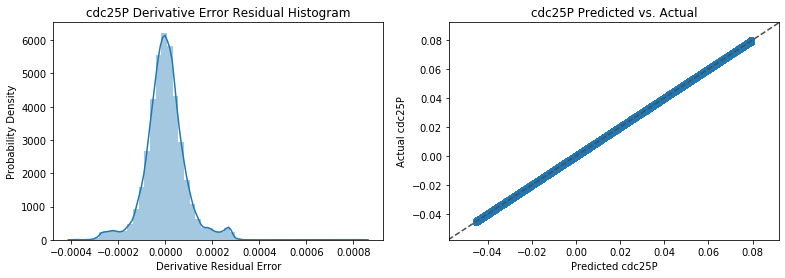

wee1P RMSE: 2.5833549064907327e-07 standard deviation: 0.000141224831028362


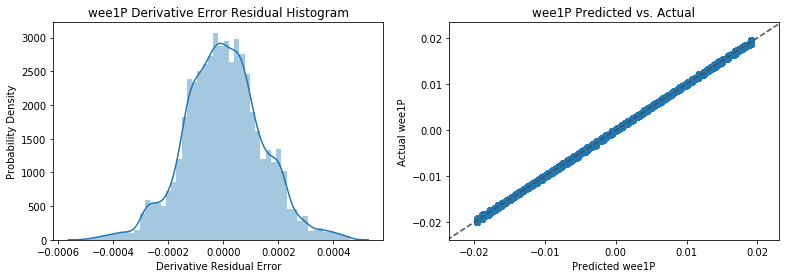

IEP RMSE: -6.88995546488444e-07 standard deviation: 0.00010037205302601619


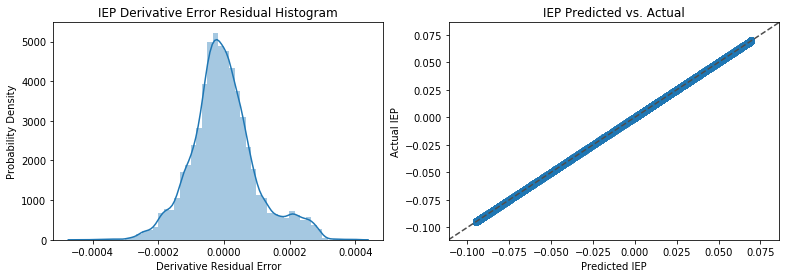

APC RMSE: 1.7475346879268875e-07 standard deviation: 7.959877775718722e-05


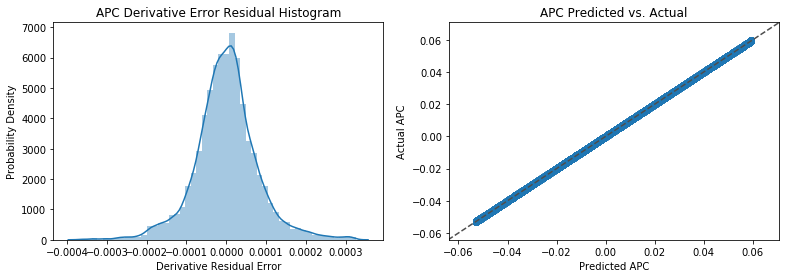

Total Derivative Mean Error: 0.8574060113950014 Error Standard Deviation: 0.01567984002970489


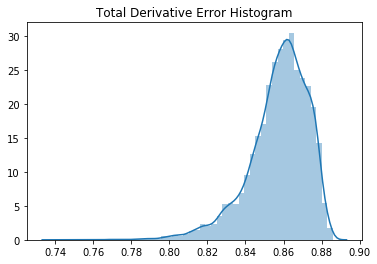

In [11]:
train_onestep.compute_error(df_train2,rf_dict2,plot=True,model_type=model_type)

Oscillating system -> derivative is also oscillating.
* Random Forest/ Decision tree will have a difficult time partitioning the feature space (features are correlated).
* Linear Regression / Polynomial Regression (works locally but not globally, true underlying distribution is trigonometric) -- this also includes having prior knowledge about the form of the governing equations
* Neural Network -- will have no problem approximating oscillating function with sigmoid (logistic) activation.

$$ y = f(x) + \epsilon$$
noise is zero and gaussian-like: distribution of the regressor is centered on the true target --> estimate is bias-free.

In [ ]:
# now we make predictions via numerical integration
# note that in predict_integrate, the function expects a normal dataframe and not the time-series multi-index dataframe

time_points, predictions = predict_onestep.predict_integrate(steady_state, steady_state, rf_dict1, target_list, feature_list, title='cell cycle', plot=True,model_type=model_type, subplots=(4,2))

In [ ]:
time_points, predictions = predict_onestep.predict_integrate(steady_state, steady_state, rf_dict2, target_list, feature_list, title='cell cycle', plot=True,model_type=model_type, subplots=(4,2))